## 5.1 확률론적 선형 회귀모형

OLS(Ordinary Least Square) 방법을 사용하면 데이터에 대한 확률론적인 가정이 없어도 최적의 가중치를 계산할 수 있었다. 그러나 계산한 가중치가 어느 정도의 신뢰도를 가지는지 확인할 수 있는 방법이 없다. 

예를 들어 보스턴 집값의 선형 회귀모형에서 OLS로 계산한 범죄율에 대한 가중치는 약 $-0.1080$이었다. 만약 이 값이 정확한 값이라면 집값은 범죄율에 반비례한다는 결론을 내릴 수 있다. 하지만 $-0.1080$은 표본에서 계산된 추정치일 뿐이며 추정 오차가 있을 수 있다. 만약 추정 오차의 크기가 $0.0001$ 수준이라면 실제 가중치는 $-0.1080 \pm 0.0001$ 즉, $-0.1081 \sim -0.1079$ 정도이고 집값이 범죄율에 반비례한다는 결론은 바뀌지 않을 것이다. 하지만 만약 추정 오차의 크기가 $0.2$ 수준이라면 실제 가중치는 $-0.3081 \sim 0.0920$ 정도의 범위가 된다. 다시 말해 진짜 가중치는 0이 될 수도 있고 양수가 될 수 있다. 만약 가중치가 0이라면 범죄율과 집값은 아무런 상관 관계가 없다는 결론이 나온다. 만약 가중치가 양수이면 집값은 범죄율에 정비례한다는 결론이 나올 수도 있다. 즉 가중치의 오차 범위 혹은 신뢰 구간을 계산할 수 없다면 OLS 결과로부터 실질적인 결론을 이끌어내기 어렵다.


### 부트스트래핑

부트스트래핑(bootstrapping)은 회귀분석에 사용한 표본 데이터가 달라질 때 회귀분석의 결과는 어느 정도 영향을 받는지를 알기 위한 방법이다. 

OLS로 구한 가중치의 추정값은 표본 데이터에 따라 달라진다. 만약 여러가지 다른 표본 데이터 집합이 있다면 이 데이터들을 넣어보면서 가중치가 어느 정도 달라지는지에 대한 감을 얻을 수 있을 것이다. 그러나 현실적으로는 추가적인 데이터를 얻기 어렵기 때문에 부트스트래핑 방법에서는 기존의 데이터를 재표본화(re-sampling)하여 여러가지 다양한 표본 데이터 집합을 만드는 방법을 사용한다. 재표본화는 기존의 $N$개의 데이터에서 다시 $N$개의 데이터를 선택하되 중복 선택도 가능하게 한다(unordered resampling with replacement). 

직접 부트스트래핑을 실시해 보자. 다음과 같은 선형 회귀 모형을 따르는 100개의 가상 데이터를 생성한다. 모형에 사용된 모수는 상수항이 $w_0=0$,  기울기가 $w_1=42.3855$이다.

$$ y = w_0 + w_1 x + \epsilon $$

In [1]:
from sklearn.datasets import make_regression

X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20,
                              coef=True, random_state=0)
coef

array(42.38550486)

이 표본 데이터를 기반으로 회귀분석을 실시한다.

In [2]:
dfX0 = pd.DataFrame(X0, columns=["X1"])
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(y, columns=["y"])

model = sm.OLS(dfy, dfX)
result = model.fit()

추정된 가중치값은 `params` 속성에 저장되어 있다. 상수항의 추정치가 $\hat{w}_0=-1.628364$, 기울기의 추정치가 $\hat{w}_1=42.853356$로 실제 모수와 다르다는 것을 알 수 있다.

In [3]:
result.params

const    -1.628364
X1       42.853356
dtype: float64

다음으로 이 데이터를 재표본화하여 다른 데이터 집합을 만들고 이 데이터를 기반으로 다시 회귀분석을 한다. 여기에서는 이러한 회귀분석을 1,000번 반복한다. 그 결과로써 1,000개의 다른 가중치 추정값이 나오게 된다.

In [4]:
%%time
N = 1000
params_w0 = np.zeros(N)
params_w1 = np.zeros(N)
for i in range(N):
    idx = np.random.choice(len(dfy), len(dfy), replace=True)
    dfX2 = dfX.iloc[idx, :]
    dfy2 = dfy.iloc[idx]
    r = sm.OLS(dfy2, dfX2).fit()
    params_w0[i] = r.params.const
    params_w1[i] = r.params.X1

CPU times: user 1.39 s, sys: 170 ms, total: 1.56 s
Wall time: 1.38 s


전체 가중치 추정값 집합을 히스토그램으로 나타내면 다음과 같다.

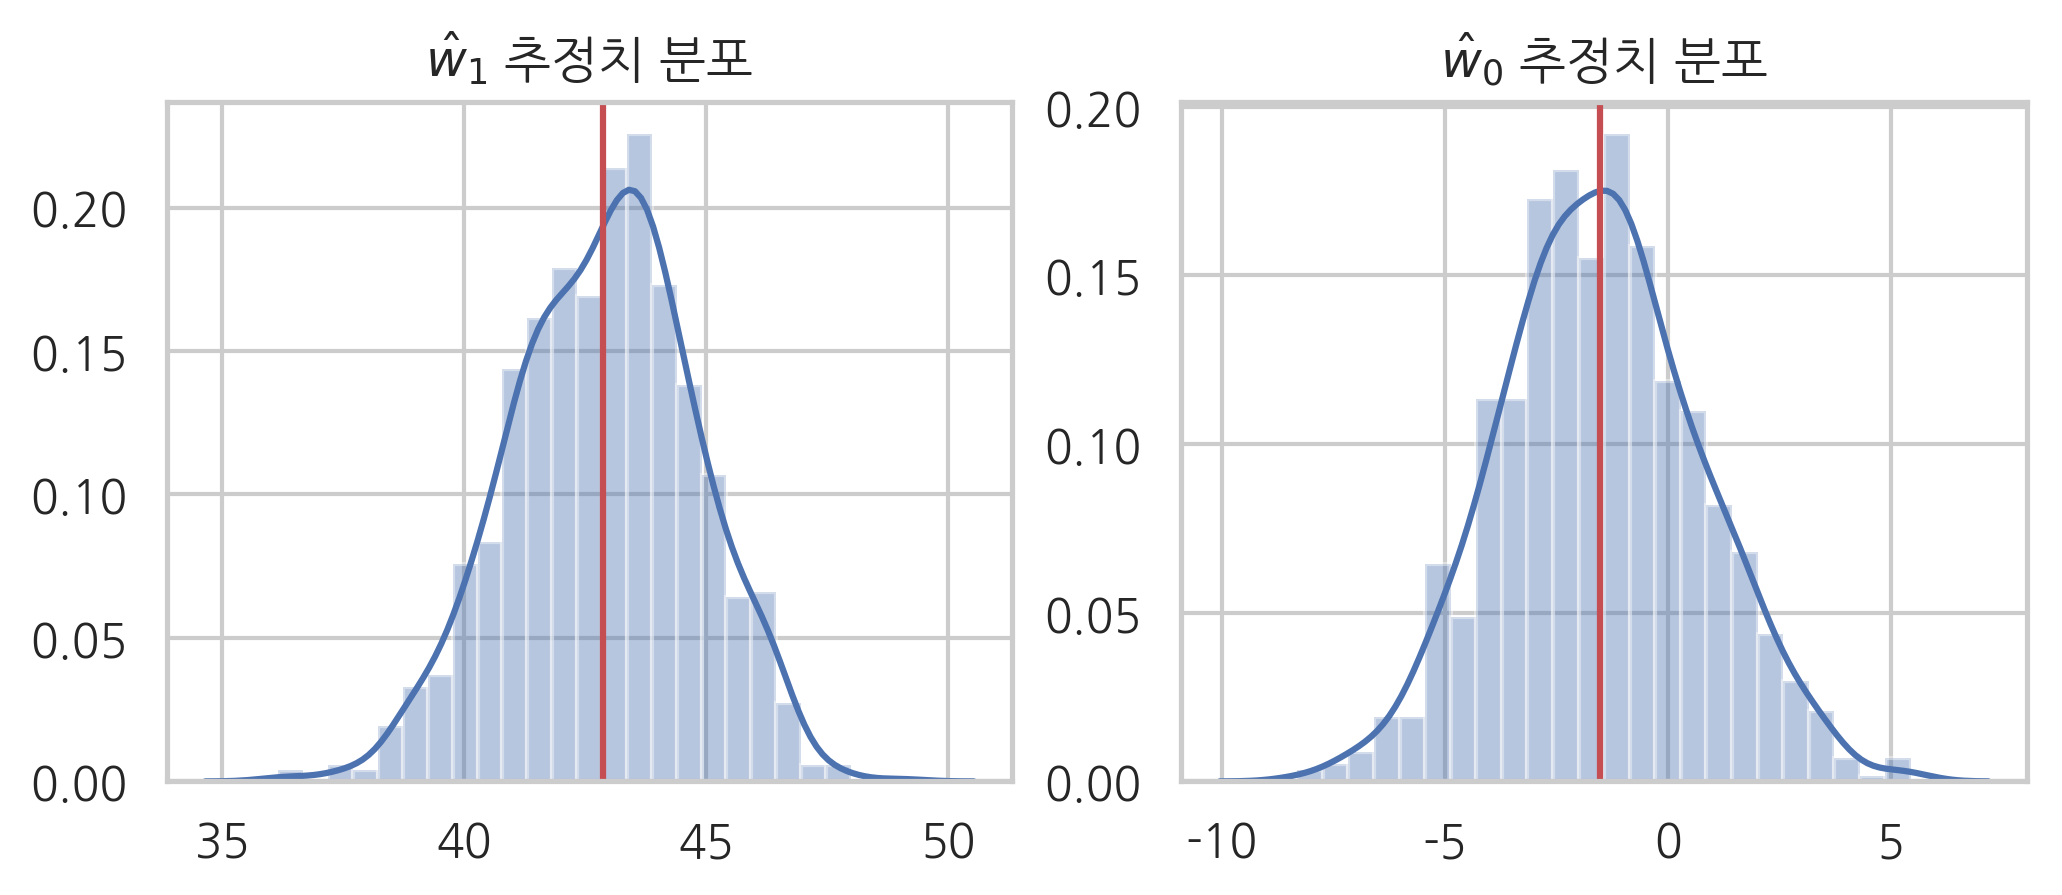

In [5]:
plt.figure(figsize=(8, 3))

ax1 = plt.subplot(121)
sns.distplot(params_w1, ax=ax1)
plt.axvline(params_w1.mean(), c='r')
plt.title("$\hat{w}_1$ 추정치 분포")

ax2 = plt.subplot(122)
sns.distplot(params_w0, ax=ax2)
plt.axvline(params_w0.mean(), c='r')
plt.title("$\hat{w}_0$ 추정치 분포")
plt.show()

추정치 분포의 평균과 분산은 다음과 같다. 기울기의 추정치 분포는 평균이 $42.92$, 표준편차가 $1.92$이다. 대부분의 데이터가 $42.92 \pm 3.84$ ($\bar{x} \pm 2s$) 사이에 있다. 따라서 오차가 큰 경우에도 0 혹은 음수가 될 가능성은 적다.

In [6]:
params_w1.mean(), params_w1.std()

(42.8795965564626, 1.8917553947290568)

그런데 상수항의 추정치 분포는 평균이 $-1.67$, 표준편차가 $2.16$이다. 대부분의 데이터가 $-1.67 \pm 4.32 \; (-5.99 \sim 2.65)$ 사이에 있기 때문에 0일 수도 있고 혹은 음수일 수도 있다.

In [7]:
params_w0.mean(), params_w0.std()

(-1.5193782287648, 2.235070026749657)

이 결과를 statsmodels의 `summary` 메서드로 출력한 보고서와 비교해보면 추정치의 표준편차와 비슷한 값이 `std err`이라는 이름으로 표시되어 있고 $\bar{x} \pm 2s$로 추정한 구간과 비슷한 값이 `[0.025      0.975]` 열 아래에 표시되어 있다. 예를 들어 상수항 추정치는 `std err`가 2.163 이고 `[0.025      0.975]`열 값이 $-5.920 \sim 2.663$이다.

In [8]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Mon, 17 Jun 2019   Prob (F-statistic):           2.21e-36
Time:                        20:16:17   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.4

하지만 이 보고서의 값은 부트스트래핑을 사용하여 구한 값이 아니라 확률론적 선형 회귀모형을 사용한 것이다. 확률론적 선형 회귀모형을 쓰면 부트스트래핑처럼 많은 계산을 하지 않아도 빠르고 안정적으로 가중치 추정값의 오차를 구할 수 있다.

### 확률론적 선형 회귀모형

확률론적 선형 회귀모형에서는 데이터가 확률 변수로부터 생성된 표본이라고 가정한다. 구체적인 가정은 다음과 같다.

#### (1) 선형 정규 분포 가정

선형 회귀분석의 기본 가정은 종속 변수 $y$가 독립 변수 $x$의 선형 조합으로 결정되는 기댓값과 고정된 분산 $\sigma^2$을 가지는 가우시안 정규 분포라는 것이다.

$$ y \sim \mathcal{N}(w^Tx, \sigma^2) $$

y의 확률 밀도 함수는 다음처럼 쓸 수 있다. 이 식에서 모수 벡터 $\theta=(w, \sigma^2)$이다.

$$ p(y \mid x, \theta) = \mathcal{N}(y \mid w^Tx, \sigma^2 ) $$

이 관계식을 잡음(disturbance) $ \epsilon$ 개념으로 변환하면 더 간단하게 표현할 수 있다.

$$ \epsilon = y - w^Tx $$


$$ p(\epsilon \mid \theta) = \mathcal{N}(0, \sigma^2 ) $$ <br>


여기에서 주의할 점은

> **x, y 중 그 어느 것도 그 자체로 정규 분포일 필요는 없다**

는 것이다. 

$y$도 $x$에 대해 **조건부로 정규 분포**를 이루는 것이지 $y$ 자체가 무조건부로 정규분포는 아니다.

#### (2) 외생성(Exogeneity) 가정

잡음 $\epsilon$의 기댓값은 독립 변수 $x$의 크기에 상관없이 항상 0이라고 가정한다. 이를 외생성(Exogeneity) 가정이라고 한다.

$$ \text{E}[\epsilon \mid x] = 0$$ 

외생성 가정으로부터와 잡음 $\epsilon$의 무조건부 기댓값이 0임을 증명할 수 있다. 

$$ \text{E}[\epsilon] = \text{E}[\text{E}[\epsilon \mid x]] = 0$$

역은 성립하지 않는다. 즉 조건부 기댓값이 0이면 기댓값은 0이지만 기댓값이 0이라고 조건부 기댓값이 0이 되지는 않는다.

그리고 같은 가정으로부터 잡음 $\epsilon$와 독립 변수 $x$가 상관 관계가 없다는 것도 증명할 수 있다.

$$ \text{E}[\epsilon x] = \text{E}[\text{E}[\epsilon x \mid x]] = \text{E}[x \text{E}[\epsilon\mid x]] = 0$$

#### (3) 조건부 독립 가정

$i$번째 표본의 잡음 $\epsilon_i$와 $j$번째 표본의 잡음 $\epsilon_j$의 공분산 값이 $x$와 상관없이 항상 0이라고 가정한다.

$$ \text{Cov}[\epsilon_i, \epsilon_j \mid x] = 0 \;\; (i,j=1,2,\ldots,N) $$ 

이는 $i$번째 표본의 잡음 $\epsilon_i$와 $j$번째 표본의 잡음 $\epsilon_j$는 서로 독립이라는 가정과 같다.

이 가정과 위의 다른 가정들로부터 다음을 증명할 수 있다.

$$ \text{E}[\epsilon_i \epsilon_j] = 0 \;\; (i,j=1,2,\ldots,N) $$

잡음 벡터 $\epsilon$의 공분산 행렬이 대각행렬이 되어야 한다는 조건과 같다. (비대각 성분이 모두 0이어야 한다.)

$$\text{Cov}[\epsilon] = \text{E}[\epsilon^{} \epsilon^T] = \text{diagonal matrix} $$

#### (4) 등분산성 가정

$i$번째 표본의 잡음 $\epsilon_i$와 $j$번째 표본의 잡음 $\epsilon_j$의 분산 값이 표본과 상관없이 항상 같다고 가정한다.

잡음 벡터 $\epsilon$의 공분산 행렬이 항등행렬 형태가 되어야 한다는 조건과 같다.

$$\text{Cov}[\epsilon] = \text{E}[\epsilon^{} \epsilon^T] = \sigma^2I $$

### 최대 가능도 방법을 사용한 선형 회귀분석

확률론적 선형 회귀모형의 가정과 최대 가능도 방법(Maximum Likelihood Estimation)을 사용하여 가중치 벡터 $w$의 값을 구해보자.

가능도는 다음과 같다.


$$
\begin{eqnarray}
p(y_{1:N} \,\big|\, x_{1:N}, \theta)
&=& \prod_{i=1}^N \mathcal{N}(y_i \,\big|\, w^T x_i , \sigma^2) \\
&=& \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left\{-\frac{(y_i-w^T x_i)^2}{2\sigma^2} \right\}  \\
\end{eqnarray}
$$

계산을 쉽게하기 위해 Log를 적용하여 로그 가능도(log-likelihood)를 구한다.

$$
\begin{eqnarray}
\text{LL}  
&=& \log p(y_{1:N} \,\big|\, x_{1:N}, \theta) \\
&=& \log \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left\{-\frac{(y_i-w^T x_i)^2}{2\sigma^2} \right\}  \\
&=& -\dfrac{1}{2\sigma^2} \sum_{i=1}^N (y_i-w^T x_i)^2 - \dfrac{N}{2} \log{2\pi}{\sigma^2}  \\
\end{eqnarray}
$$



이를 행렬로 표시하면 다음과 같다.


$$
\text{LL}  =  -C_1 (y - Xw)^T(y-Xw) - C_0 = -C_1(w^TX^TXw -2 y^TXw + y^Ty) - C_0
$$

$$
C_1 =  -\dfrac{1}{2\sigma^2}
$$

$$
C_0 =  \dfrac{N}{2} \log{2\pi}{\sigma^2} 
$$

최적화하면 OLS와 동일한 결과를 얻을 수 있다.


$$
\dfrac{d}{dw} \text{LL} = -C_1 \left( 2X^TX \hat{w} - 2X^Ty \right) = 0
$$

$$
\hat{w} = (X^TX)^{-1}X^T y
$$

최대 가능도 방법에서도 OLS의 직교 방정식과 같은 직교 방정식을 얻을 수 있다.

$$ X^TX \hat{w} - X^Ty = 0 $$

$$ X^T(X \hat{w} - y) = X^T(\hat{y} - y) = X^Te = 0 $$


### 잔차의 분포

확률론적 선형 회귀모형에 따르면 회귀분석에서 생기는 **잔차 $e = y - \hat{w}^Tx$ 도 정규 분포를 따른다**. 다음과 같이 증명할 수 있다.

확률론적 선형 회귀모형의 잡음 $\epsilon$와 잔차 $e$는 다음과 같은 관계를 가진다.

$$  \hat{y} = X\hat{w} = X (X^TX)^{-1}X^T y = Hy $$

이 행렬 $H$은 **Hat 행렬** 혹은 **프로젝션(projection) 행렬** 또는 **영향도(influence) 행렬**이라고 부르는 대칭 행렬이다.

Hat 행렬을 이용하면 잔차는 다음처럼 표현된다.

$$ e = y - \hat{y}= y - Hy = (I - H) y = My $$

이 행렬 $M$은 **잔차(residual) 행렬**이라고 부른다. 

확률적 선형 회귀 모형의 가정을 적용하면,

$$ e = My = M (Xw + \epsilon) = MXw + M\epsilon $$

그런데

$$
MX = 0
$$

에서

$$ e =  M\epsilon $$

즉, **잔차 $e$는 잡음 $\epsilon$의 선형 변환(linear transform)**이다. 정규 분포의 선형 변환은 마찬가지로 정규 분포이므로 잔차도 정규 분포를 다른다.

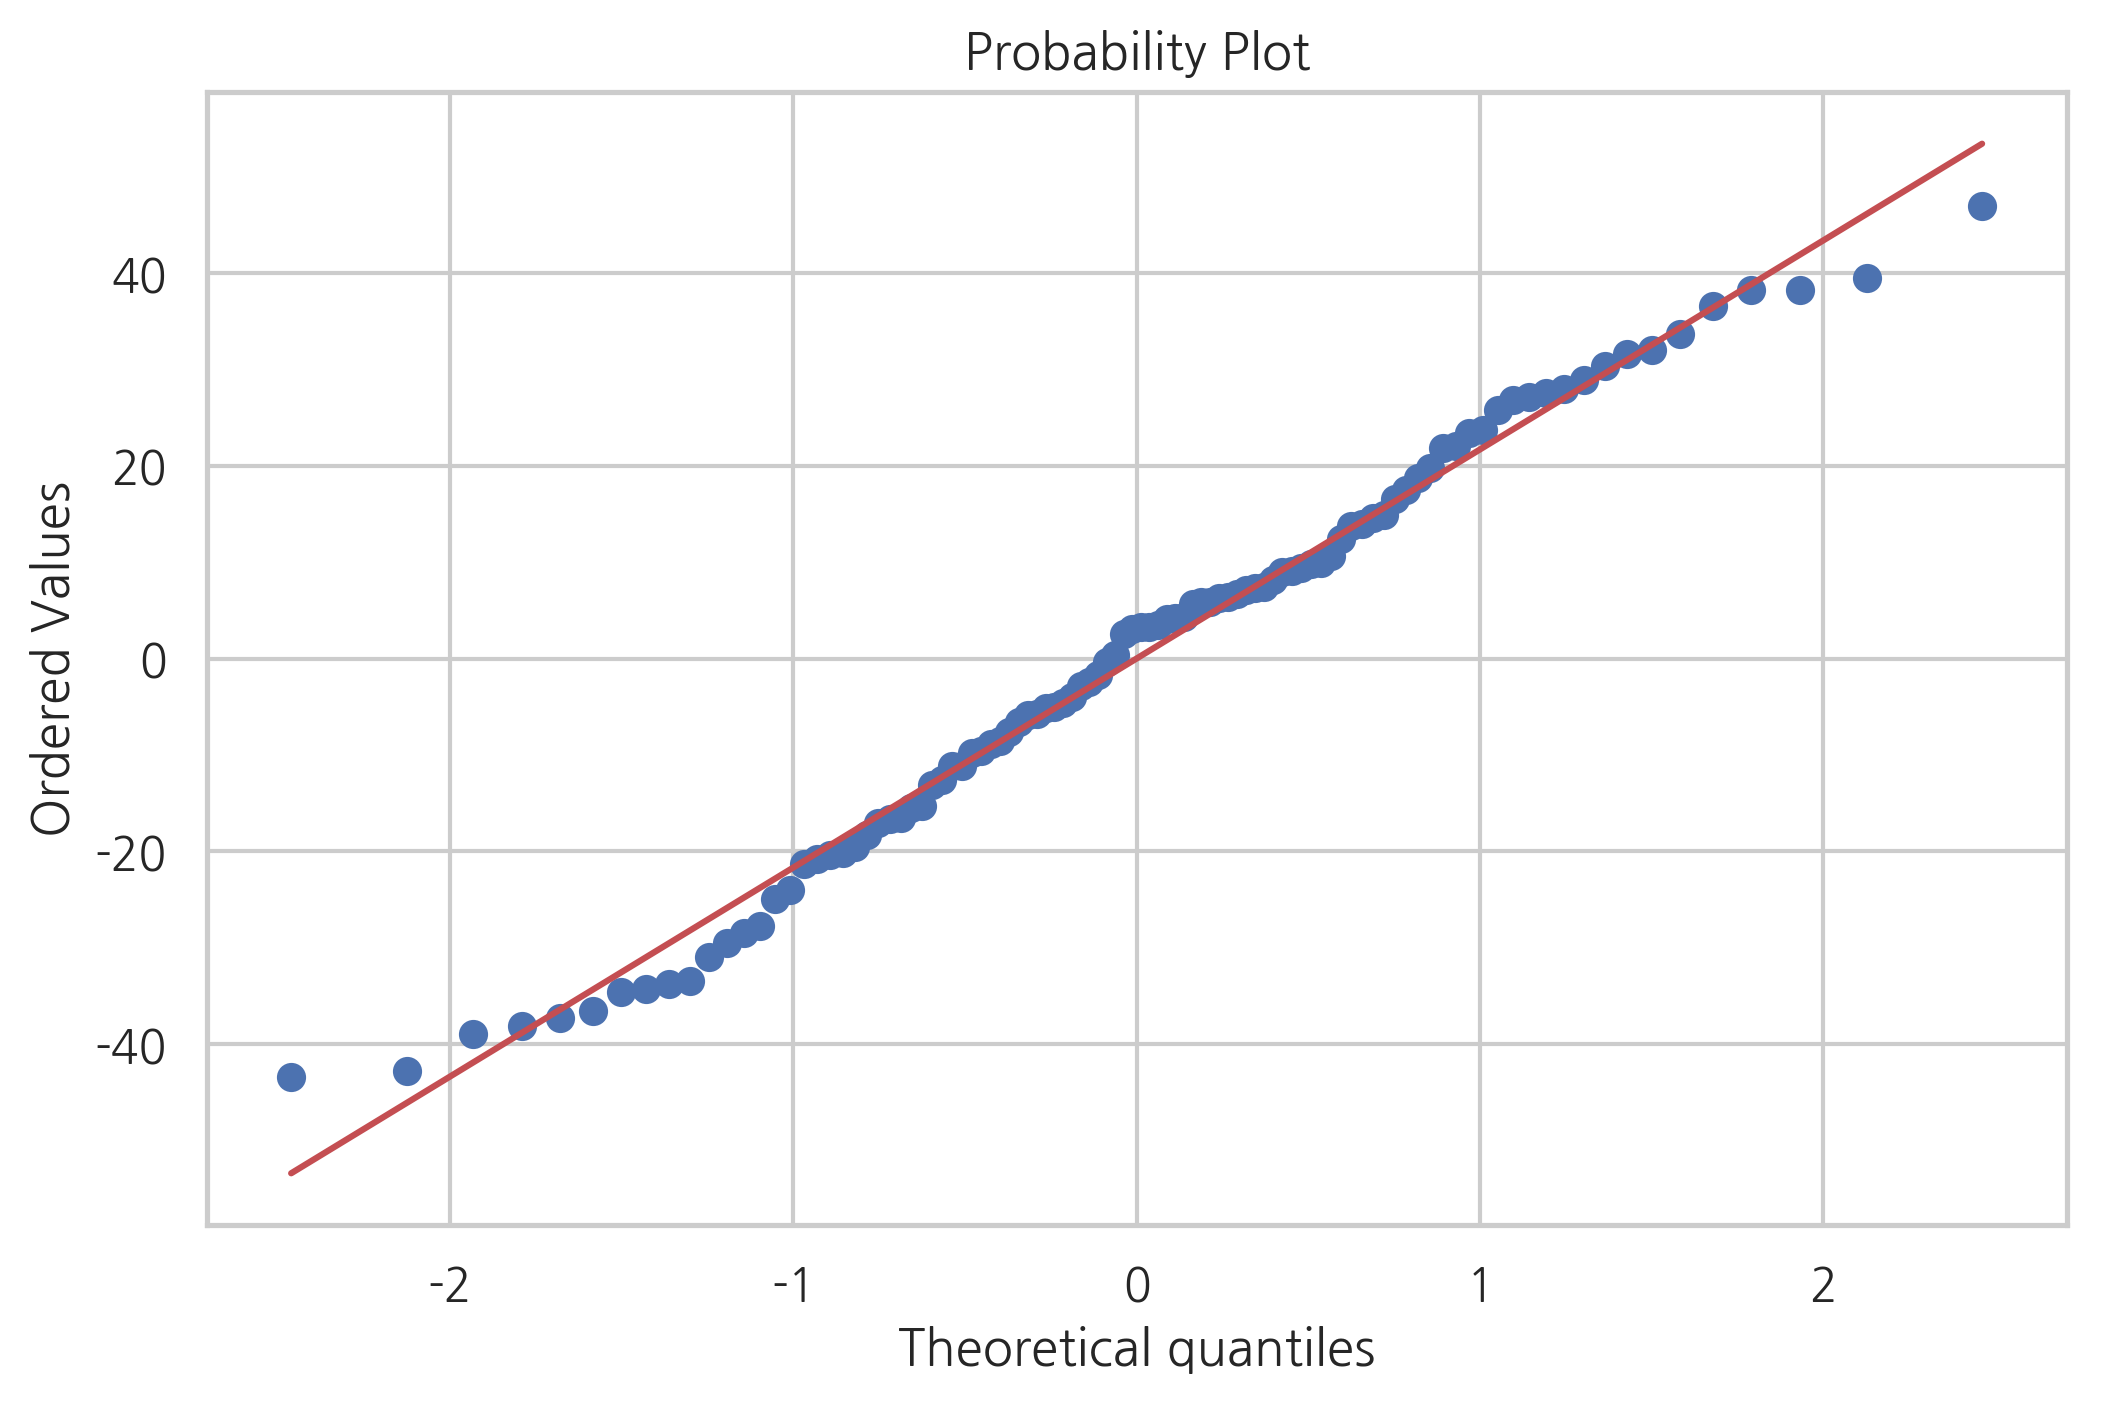

In [9]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

잔차의 정규성은 다음과 같이 정규성 검정을 통해 살펴볼 수도 있다.

In [10]:
test = sm.stats.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  3.523
P-value     :  0.172


In [11]:
test = sm.stats.jarque_bera(result.resid)
for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test):
    print("%-12s: %6.3f" % xi)

Jarque-Bera :  2.059
P-value     :  0.357
Skew        : -0.073
Kurtosis    :  2.312


또한 오차의 기댓값이 $x$와 상관없이 0이므로 **잔차의 기댓값도 $x$와 상관없이 0**이어야 한다. 

$$ \text{E}[e | x ] = 0 $$

다음은 $x$값이 달라짐에 따라 잔차의 분포가 어떻게 바뀌는 지를 살펴보기 위한 것이다. $x$값이 달라져도 분포의 형태가 크게 바뀌지 않음을 알 수 있다.

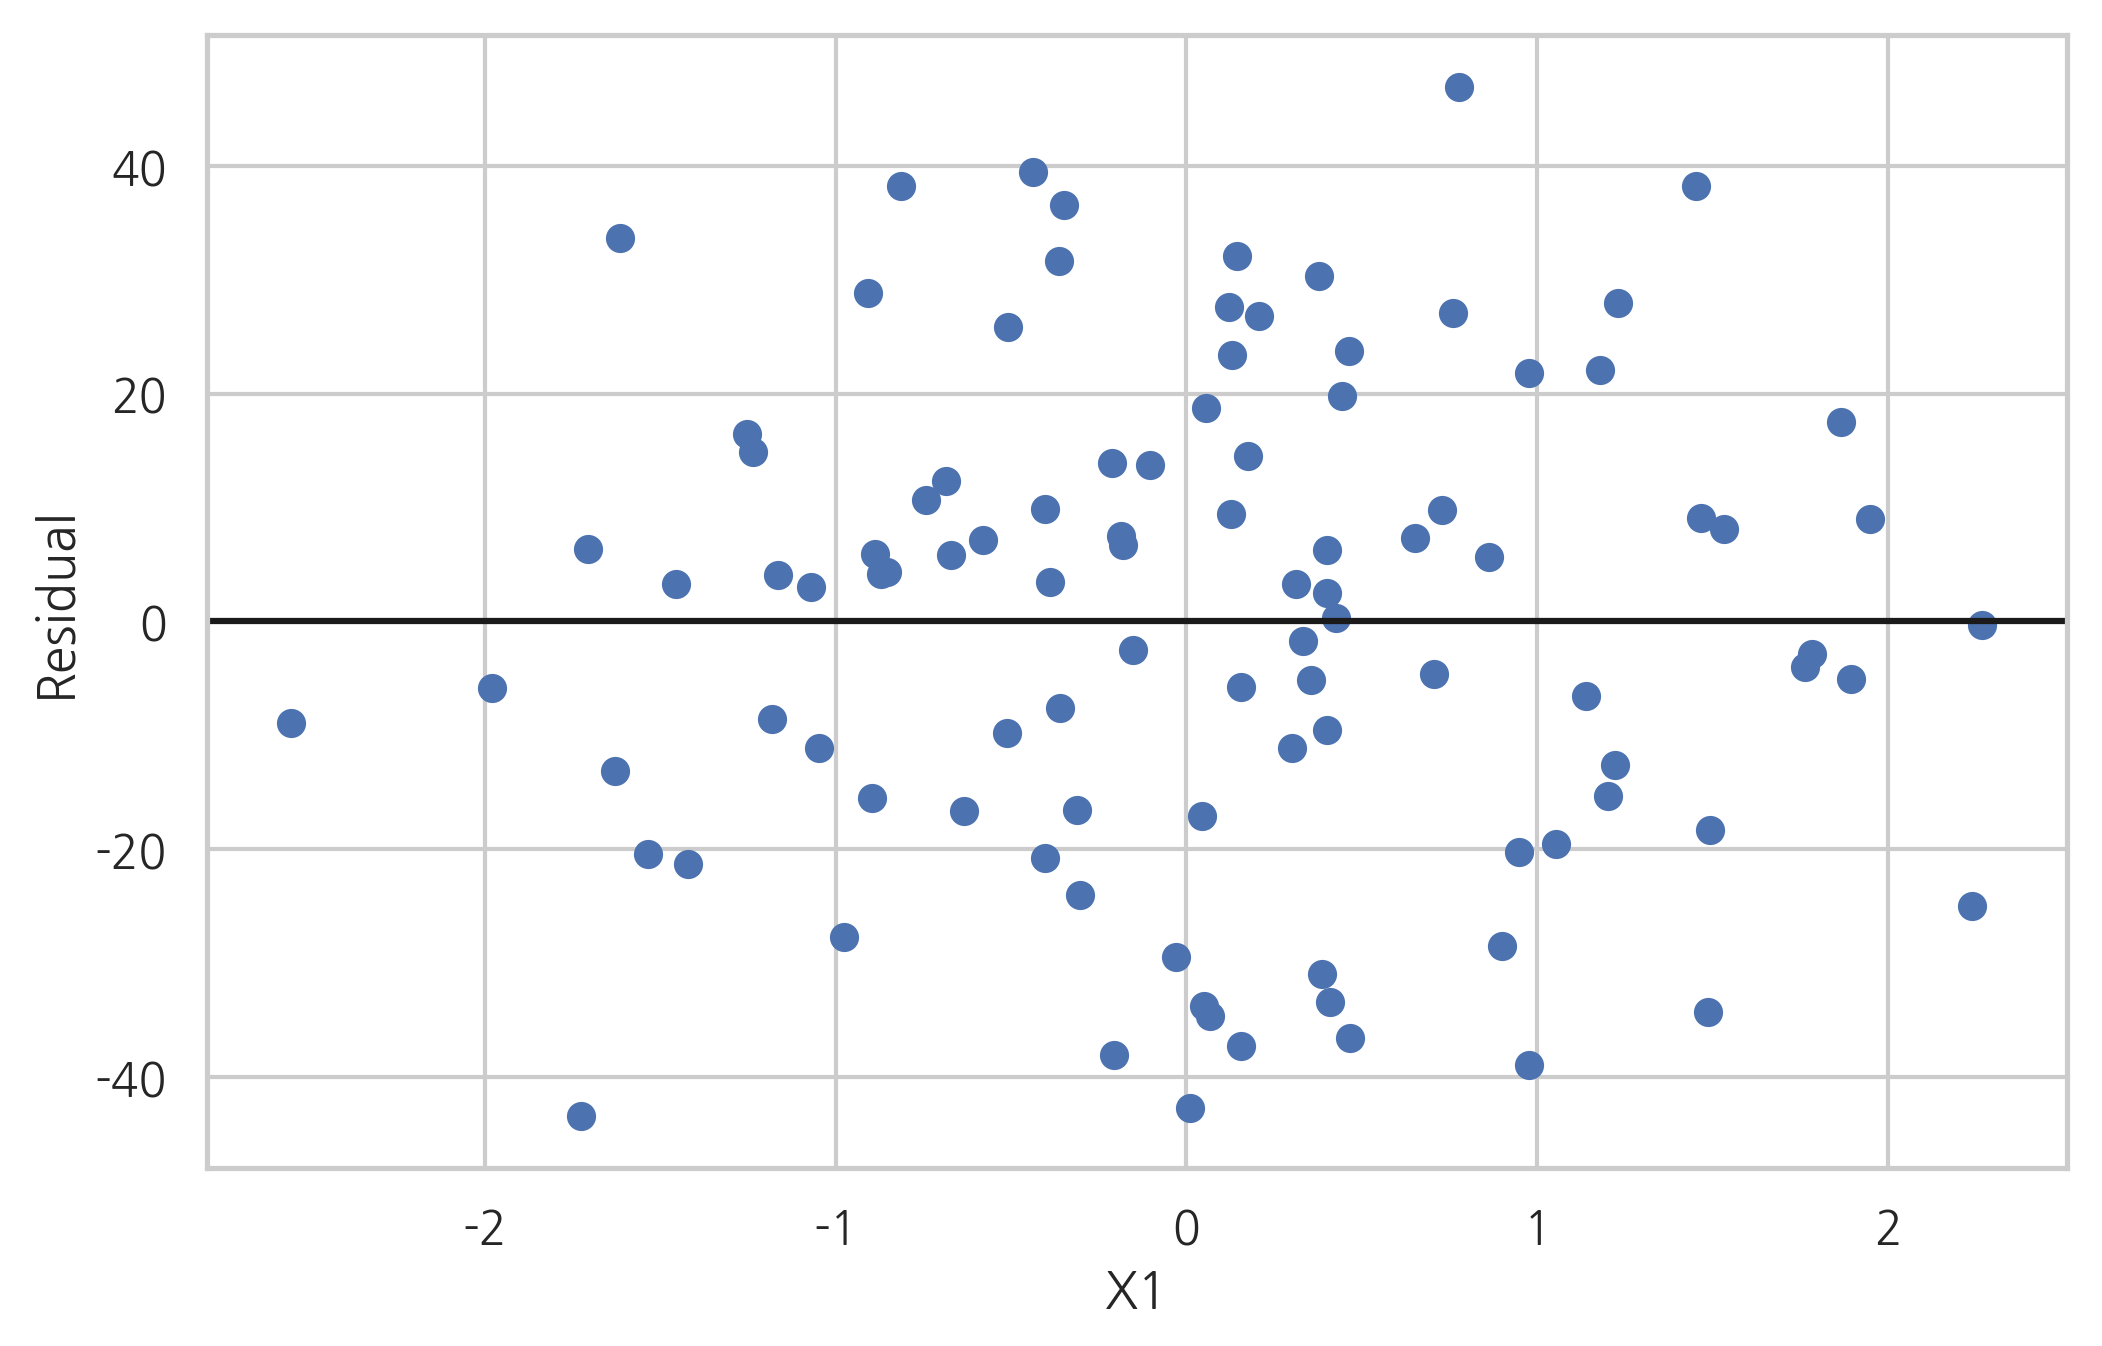

In [12]:
plt.plot(X0, result.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("X1")
plt.ylabel("Residual")
plt.show()

다음은 $x$가 $e$에 미치는 영향을 살피기 위해 $0 < x < 1$인 구간과 $1 < x < 2$인 구간으로 나누어 $e$ 분포의 모양을 살펴본 것이다. 둘 다 기댓값이 0에 가깝고 분산의 크기가 비슷함을 알 수 있다.

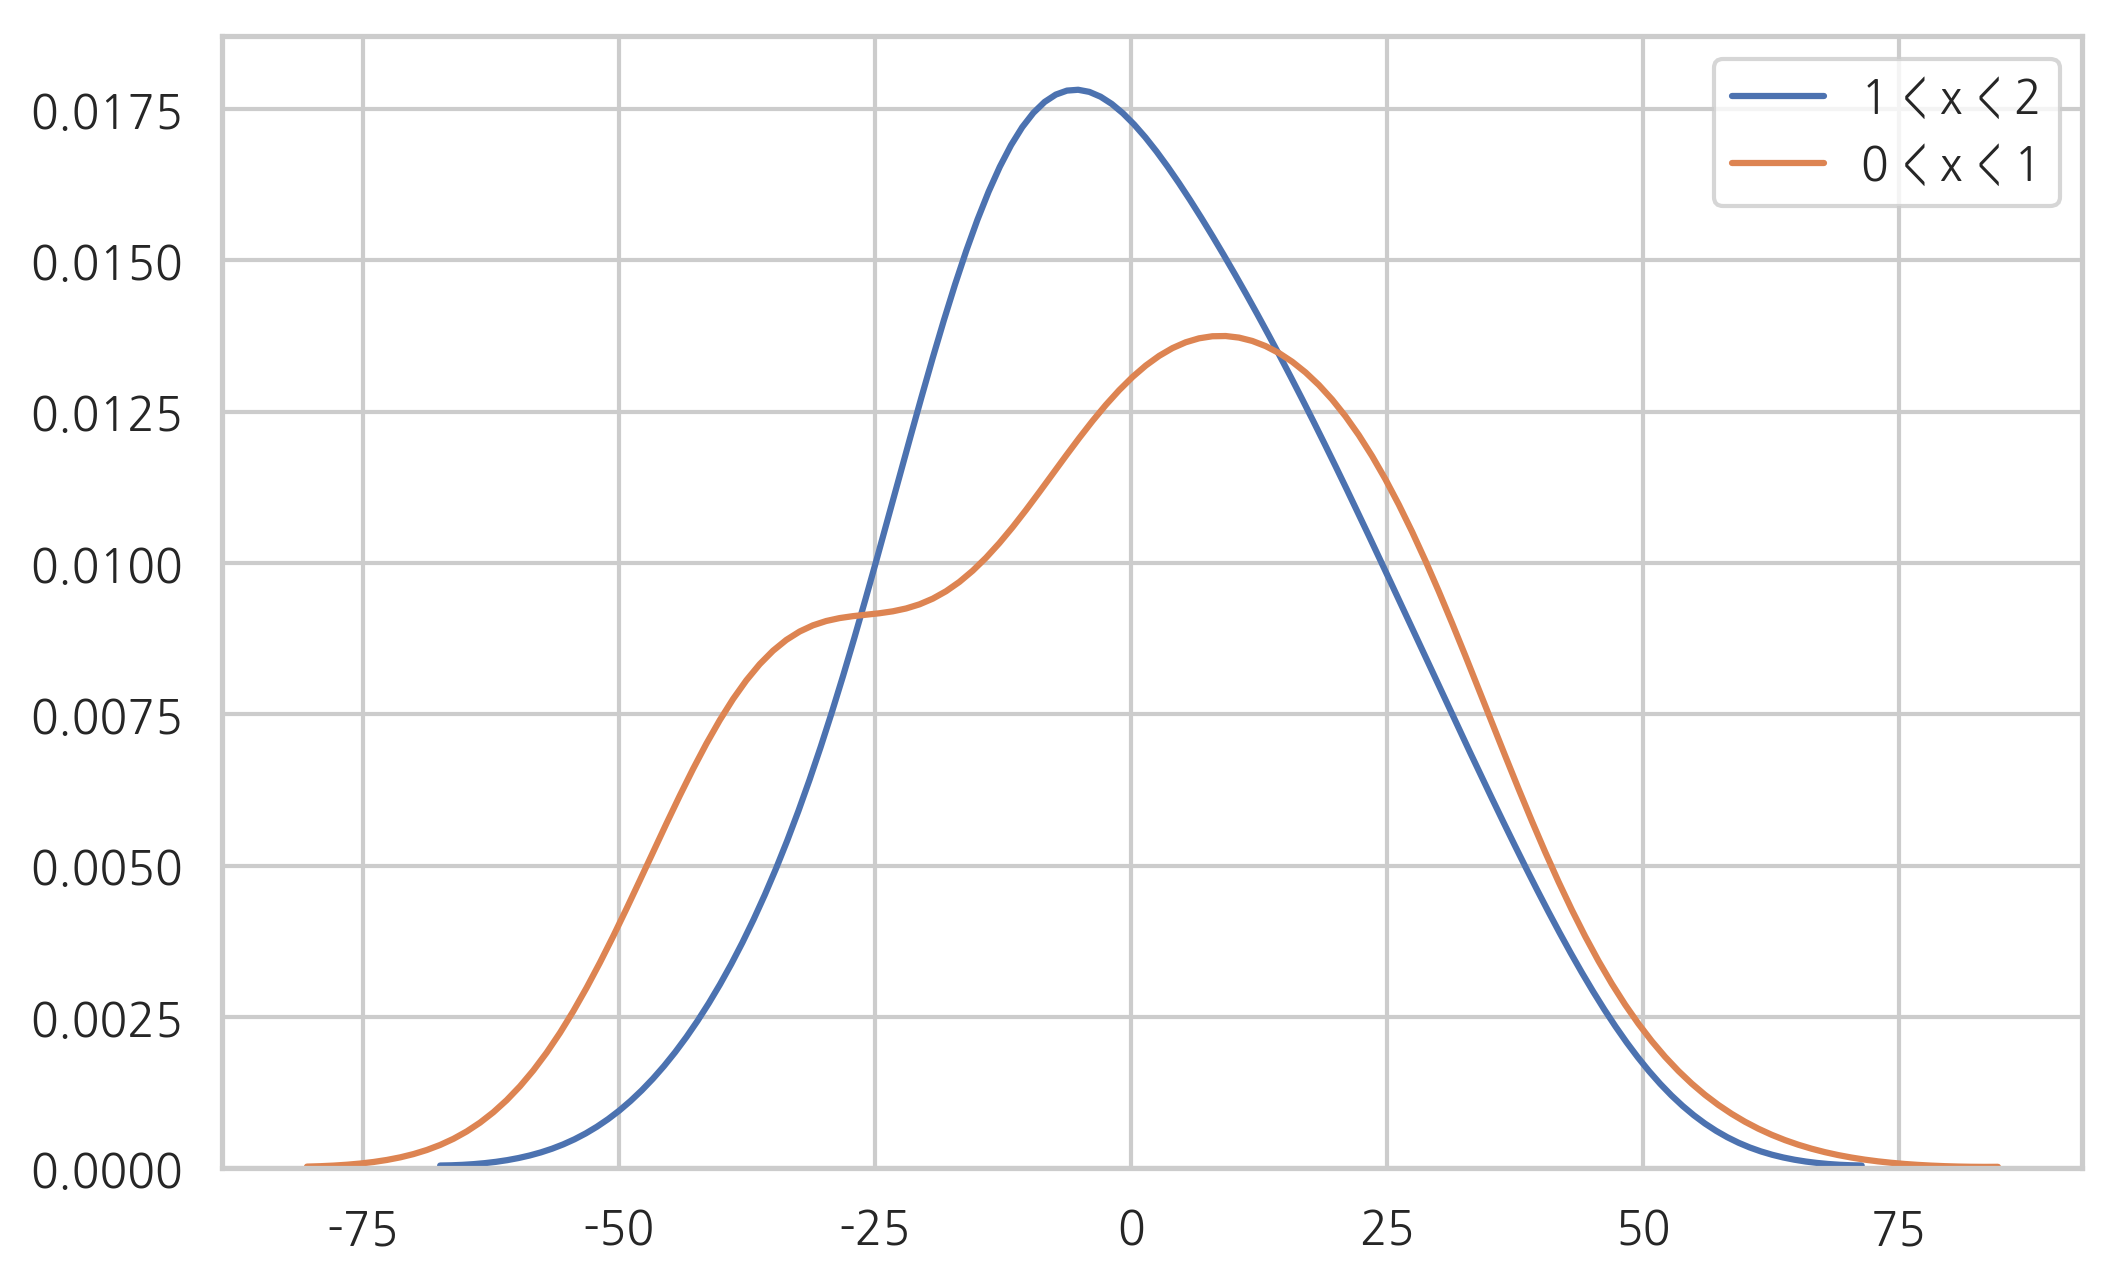

In [13]:
sns.kdeplot(result.resid[((1 < X0) & (X0 < 2)).flatten()], label="1 < x < 2")
sns.kdeplot(result.resid[((0 < X0) & (X0 < 1)).flatten()], label="0 < x < 1")
plt.legend()
plt.show()

### 회귀 계수의 표준 오차

가중치의 예측치 $\hat{w}$ 도 정규 분포 확률 변수인 $\epsilon$의 선형 변환이므로 정규 분포를 따른다.

$$  
\begin{eqnarray}
\hat{w} 
&=& (X^TX)^{-1} X^T y \\
&=& (X^TX)^{-1} X^T (X w + \epsilon) \\
&=& w + (X^TX)^{-1} X^T \epsilon \\
\end{eqnarray}
$$

$\hat{w}$의 기댓값은 다음과 같다.

$$  
\begin{eqnarray}
\text{E}[\hat{w}] 
&=&  \text{E}[ w + (X^TX)^{-1} X^T \epsilon ] \\
&=&  w + (X^TX)^{-1} X^T \text{E}[ \epsilon ] \\
&=& w
\end{eqnarray}
$$

따라서 $\hat{w}$는 $w$의 비편향 추정값(unbiased estimate)이다.

$\hat{w}$의 공분산은 다음과 같다.

$$
\begin{eqnarray}
\text{Cov}[\hat{w}] 
&=& E[(\hat{w} - w)(\hat{w} - w)^T] \\
&=& E[((X^TX)^{-1} X^T \epsilon)((X^TX)^{-1} X^T \epsilon)^T] \\
&=& E[(X^TX)^{-1} X^T \epsilon \epsilon^T X(X^TX)^{−1} ] \\
&=& (X^TX)^{-1} X^T E[\epsilon \epsilon^T] X(X^TX)^{−1} \\
&=& (X^TX)^{-1} X^T (\sigma^2 I) X(X^TX)^{−1} \\
&=& \sigma^2  (X^TX)^{-1}
\end{eqnarray}
$$


그런데 잡음의 분산 $\text{E}[\epsilon^2] = \sigma^2$의 값은 알지 못하므로 다음과 같이 잔차의 분산 $\text{E}[e^2]$으로부터 추정한다.


$$
\begin{eqnarray}
\text{E}[e^2] 
&=& \text{E}[(M\epsilon)^2] \\
&=& \text{E}[(\epsilon^T M^T)(M\epsilon)] \\
&=& \text{E}[ \epsilon^T M \epsilon] \\
&=& \text{E}[ \text{tr}(\epsilon^T M \epsilon) ] \\
&=& \text{tr}( \text{E}[ M \epsilon \epsilon^T ]) \\
&=& \text{tr}( M \text{E}[\epsilon \epsilon^T ]) \\
&=& \text{tr}( M \sigma^2 I ) \\
&=& \sigma^2 \text{tr}(M) \\
&=& \sigma^2 \text{tr}(I - X(X^TX)^{-1}X^T) \\
&=& \sigma^2 \left( \text{tr}(I) - \text{tr}((X^TX)^{-1}(X^TX))  \right) \\
&=& \sigma^2 (N-K) \\
\end{eqnarray}
$$

여기에서 $N$은 표본 데이터의 수, $K$는 $X$ 행렬의 열의 수 즉, 모수의 갯수이다. 상수항을 포함한 선형 모형이라면 모수의 갯수는 입력 데이터의 차원의 수 $D$에 1을 더한 값이 된다.

$$ K = D + 1 $$



따라서 잡음에 대한 비편향 표본분산은 다음과 같다. 

$$ s^2 = \dfrac{e^Te}{N-K} = \dfrac{RSS}{N-K} $$

$\hat{w}$의 (공)분산의 추정값은 다음과 같다.

$$ \text{Cov}[\hat{w}] \approx s^2(X^TX)^{-1}$$

이 공분산 행렬에서 우리가 관심을 가지는 값은 $w_i$의 분산을 뜻하는 대각 성분이다.

$$\text{Var}[\hat{w}_i]  = \left( \text{Cov}[\hat{w}] \right)_{ii} \;\; (i=0, \ldots, K-1)$$


이 값에서 구한 표준 편차를 **회귀 계수의 표준 오차(Standard Error of Regression Coefficient)**라고 한다.

 $$ \sqrt{\text{Var}[\hat{w}_i]} \approx {se_i} = \sqrt{s^2 \big((X^TX)^{-1}\big)_{ii}} \;\; (i=0, \ldots, K-1)$$
 
실제 가중치 계수 $w_i$와 우리가 추정한 가중치 계수 $\hat{w}_i$의 차이를 표준 오차를 나눈 값, 즉 **정규화된 모수 오차는 자유도가 $N-K$인 표준 스튜던트 t 분포를 따른다.**

$$  \dfrac{\hat{w}_i - w_i}{se_i} \sim t_{N-K} \;\; (i=0, \ldots, K-1)$$


### 단일 계수 t-검정 (Single Coefficient t-test)

정규화된 모수 오차 $\dfrac{\hat{w}_i}{se_i}$를 검정 통계량으로 사용하면 $w_i$가 0 인지 아닌지에 대한 검정을 실시할 수 있다.

$$ H_0 : \;\; w_i = 0 \;\; (i=0, \ldots, K-1)$$

만약 이 검정에 대한 유의 확률이 0에 가깝게 나온다면 위의 귀무가 설은 기각이므로 $w_i$ 값이 0일 가능성은 적다. 하지만 유의 확률이 유의 수준을 넘는 큰 값이 나온다면 반대로 $w_i$ 값이 0일 가능성이 크다. 즉, 해당 독립 변수는 종속 변수와 아무런 상관성이 없을 가능성이 있다는 뜻이다.

StatsModels `summary` 메서드가 출력하는 회귀분석 보고서에서 `std err`로 표시된 열이 모형계수의 표준오차, `t`로 표시된 열이 단일 계수 t-검정의 검정 통계량, 그리고 `P>|t|`로 표시된 열이 유의확률을 뜻한다. 

아래의 보고서에서는 첫번째 모형계수는 실제 값이 0일 가능성 즉, 상수항을 가지지 않을 가능성이 높다고 할 수 있다.

In [14]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Mon, 17 Jun 2019   Prob (F-statistic):           2.21e-36
Time:                        20:16:19   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.4

`RegressionResults` 클래스 객체는 t test 를 위한 `t_test` 메서드를 제공한다. 이 메서드를 사용하면 계수 값이 0이 아닌 경우도 테스트할 수 있다. 예를 들어 위 예제에서 귀무 가설을 다음처럼 놓고

$$ H_0: w_1 = 40 $$

x1에 대한 계수값 $w_1$을 40으로 해도 되는지 테스트할 수도 있다.

In [15]:
print(result.t_test("X1 = 40"))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            42.8534      2.142      1.332      0.186      38.603      47.104


이 검정 결과에 따르면 x1에 대한 계수를 40으로 한다고 해도 문제가 없음을 알 수 있다.

이 방법은 두 독립변수의 계수값을 비교할 때도 쓸 수 있다. 범주형 독립변수의 범주값이 가지는 유의성을 판단하는데 유용하다. 예를 들어 월평균 기온을 나타내는 nottem 데이터에서 1월과 2월의 기온이 실질적으로 같은지를 알아볼 때도 사용할 수 있다.

In [16]:
import datetime
from calendar import isleap

df_nottem = sm.datasets.get_rdataset("nottem").data 

def convert_partial_year(number):
    year = int(number)
    d = datetime.timedelta(days=(number - year) * (365 + isleap(year)))
    day_one = datetime.datetime(year, 1, 1)
    date = d + day_one
    return date

df_nottem["date0"] = df_nottem[["time"]].applymap(convert_partial_year)
df_nottem["date"] = pd.DatetimeIndex(df_nottem["date0"]).round('60min') + datetime.timedelta(seconds=3600*24)
df_nottem["month"] = df_nottem["date"].dt.strftime("%m").astype('category')
del df_nottem["date0"], df_nottem["date"]

model_nottem = sm.OLS.from_formula("value ~ C(month) + 0", df_nottem)
result_nottem = model_nottem.fit()
print(result_nottem.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     277.3
Date:                Mon, 17 Jun 2019   Prob (F-statistic):          2.96e-125
Time:                        20:16:26   Log-Likelihood:                -535.82
No. Observations:                 240   AIC:                             1096.
Df Residuals:                     228   BIC:                             1137.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
C(month)[01]    39.6950      0.518     76.691   

다음 코드에서 보듯이 1월과 2월의 기온은 실질적으로 차이가 없다. 즉, 1월과 2월이라는 범주 값을 구분하는 실익이 존재하지 않는다. 

In [17]:
print(result_nottem.t_test("C(month)[01] = C(month)[02]"))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.5050      0.732      0.690      0.491      -0.937       1.947


2월과 3월의 경우에는 구분이 필요하다는 것을 알 수 있다.

In [18]:
print(result_nottem.t_test("C(month)[03] = C(month)[02]"))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             3.0050      0.732      4.105      0.000       1.563       4.447


### 회귀분석 F-검정

개별 개수가 아닌 전체 회귀 계수가 모두 의미가 있는지 확인하는 경우에는 다음과 같은 귀무 가설을 생각할 수 있다.

$$ H_0 : w_0  = w_1 = \cdots = w_{K-1} = 0 $$

이는 전체 독립 변수 중 어느 것도 의미를 가진 것이 없다는 뜻이다. 대부분의 경우, 이 귀무가설은 기각된다. 다만 유의 확률이 얼마나 작은가에 따라서 기각되는 정도가 달라진다. 유의 확률이 작으면 작을수록 더 강력하게 기각된 것이므로 더 의미가 있는 모형이라고 할 수 있다. 따라서 여러 모형의 유의 확률을 비교하여 어느 모형이 더 성능이 좋은가를 비교할 때 이 유의 확률을 사용한다. 이러한 검정을 Loss-of-Fit 검정 또는 **회귀분석 F-검정(regression F-test)**이라고 한다.

위 보고서에서 `F-statistic`라고 표시된 `400.3`이라는 값이 회귀분석 F-검정의 검정통계량이고 `Prob (F-statistic)`로 표시된 `2.21e-36`라는 값이 유의확률이다.